#1. Install Necessary Libraries

In [1]:
# Import Necessary Libiraries
import os
import numpy as np
import tensorflow as tf
from google.colab import drive


In [ ]:
device_name     = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#2. Data Understanding

In [2]:
# google drive နဲ့ ချိတ်ပါ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
train_dir = '/content/drive/MyDrive/SeaLife/Train';
image_dir = '/content/drive/MyDrive/SeaLife/Images'


In [ ]:
splitfolders.ratio(train_dir , output = image_dir , seed=42 , ratio = (0.80,0.20) , group_prefix= None)

Copying files: 4200 files [02:10, 32.21 files/s]


In [30]:
train_dir = '/content/drive/MyDrive/SeaLife/Images/train'
test_dir = '/content/drive/MyDrive/SeaLife/Images/val'

#3. Data Preprocessing

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255,
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Shift images vertically by 20% of the height
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.2,  # Randomly zoom images by 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels (after rotation or width/height shift)

)

test_generator = ImageDataGenerator(
    rescale=1.0/255,
)

In [32]:
TARGET_SIZE = (224,224)
BATCH_SIZE = 32

train_images = train_generator.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2688 images belonging to 21 classes.
Found 672 images belonging to 21 classes.
Found 840 images belonging to 21 classes.


In [ ]:
# Get the class labels
class_labels = list(train_images.class_indices)
print("Class Labels:", class_labels)

Class Labels: ['Clams', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


#4. Modeling

In [ ]:
from tensorflow.keras.applications import ResNet50V2


# Load ResNet50V2 pre-trained on ImageNet
pretrained_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224, 3),
)

pretrained_model.trainable = False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


model = tf.keras.models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(21, activation='softmax')
])



In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_images,
    steps_per_epoch = len(train_images),
    epochs=100,
    validation_data=val_images,
    validation_steps = len(val_images),
    callbacks= early_stopping
)

Epoch 1/100
84/84 [==============================] - 65s 778ms/step - loss: 0.4260 - accuracy: 0.8653 - val_loss: 0.8365 - val_accuracy: 0.7470
Epoch 2/100
84/84 [==============================] - 55s 661ms/step - loss: 0.4094 - accuracy: 0.8605 - val_loss: 0.9362 - val_accuracy: 0.7292
Epoch 3/100
84/84 [==============================] - 55s 657ms/step - loss: 0.3890 - accuracy: 0.8713 - val_loss: 0.8945 - val_accuracy: 0.7723
Epoch 4/100
84/84 [==============================] - 67s 795ms/step - loss: 0.3517 - accuracy: 0.8802 - val_loss: 0.9157 - val_accuracy: 0.7307
Epoch 5/100
84/84 [==============================] - 56s 662ms/step - loss: 0.3508 - accuracy: 0.8769 - val_loss: 0.8747 - val_accuracy: 0.7589
Epoch 6/100
84/84 [==============================] - 55s 655ms/step - loss: 0.3296 - accuracy: 0.8910 - val_loss: 0.9392 - val_accuracy: 0.7396


In [ ]:
model.save('/content/drive/MyDrive/SeaLife/Model/resnet.h5')
model.save('/content/drive/MyDrive/SeaLife/Model/resnet.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
#Load model
# import tensorflow as tf

# Load the model from the saved file
loaded_model  = tf.keras.models.load_model('/content/drive/MyDrive/SeaLife/Model/resnet.h5')

# Verify the model architecture
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 21)                5397      
                                                                 
Total params: 24094741 (91.91 MB)
Trainable params: 529941 (2.02 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

In [7]:
loaded_model.save('my_model.h5')

from google.colab import files
files.download('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5. Evaluation

In [11]:
results = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.92372
Test Accuracy: 75.60%


In [14]:
y_predicted = loaded_model.predict(test_images)
y_pred = []
for i in y_predicted:
  print(np.argmax(i))
  print()
  y_pred.append(np.argmax(i))

27/27 [==============================] - 173s 6s/step
0

0

7

0

17

0

0

0

3

0

0

0

0

7

0

0

0

0

0

0

0

10

11

0

7

0

0

13

0

0

0

0

0

10

0

6

0

0

0

0

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

1

2

2

15

2

15

2

2

2

2

2

2

2

2

20

2

2

2

2

2

2

2

2

15

2

2

2

2

2

2

2

2

2

2

15

2

2

14

15

2

2

3

3

3

12

3

3

3

3

7

3

11

3

4

3

3

7

3

3

11

3

3

15

3

3

3

3

3

3

4

10

3

3

4

3

0

7

3

0

3

3

4

4

4

14

4

4

4

4

4

4

10

9

4

15

4

0

4

4

0

0

4

4

10

19

16

9

20

11

4

4

4

4

4

4

4

4

4

17

4

15

5

5

5

5

5

5

5

5

5

5

5

5

20

13

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

5

16

1

0

13

13

0

6

6

16

4

6

6

6

19

6

7

6

6

6

16

16

6

6

6

16

3

6

1

6

6

6

9

0

7

7

6

4

6

6

6

3

3

10

7

7

6

7

0

0

7

13

7

7

0

0

10

7

17

7

6

0

7


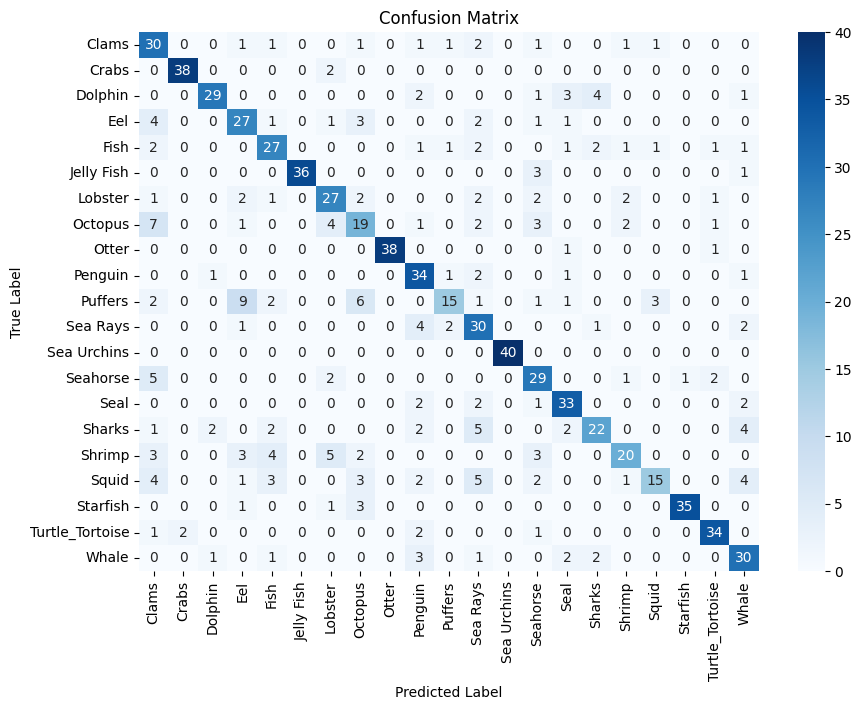

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_test = test_images.classes
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

y_test = test_images.classes.tolist()

print('Accuracy Score',accuracy_score(y_test,y_pred)*100,'%')
print('Precision Macro Score ',precision_score(y_test,y_pred,average = 'macro')*100,'%')
print('Recall_Score',recall_score(y_test,y_pred, average = 'macro')*100,'%')
print('F1_Score',f1_score(y_test,y_pred, average = 'macro')*100,'%')

Accuracy Score 75.59523809523809 %
Precision Macro Score  76.31097663866258 %
Recall_Score 75.59523809523809 %
F1_Score 75.33442296579567 %


#6. Prediction

In [ ]:
class_dictionary = test_images.class_indices
class_labels = {v: k for k, v in class_dictionary.items()}
class_names = list(class_labels.values())
class_labels

{0: 'Clams',
 1: 'Crabs',
 2: 'Dolphin',
 3: 'Eel',
 4: 'Fish',
 5: 'Jelly Fish',
 6: 'Lobster',
 7: 'Octopus',
 8: 'Otter',
 9: 'Penguin',
 10: 'Puffers',
 11: 'Sea Rays',
 12: 'Sea Urchins',
 13: 'Seahorse',
 14: 'Seal',
 15: 'Sharks',
 16: 'Shrimp',
 17: 'Squid',
 18: 'Starfish',
 19: 'Turtle_Tortoise',
 20: 'Whale'}

In [ ]:
from keras.preprocessing.image import load_img , img_to_array

image_path = '/content/drive/MyDrive/SeaLife/Images/val/Dolphin/12563623954_60252ec0e4_o.jpg'
test_image = load_img(image_path, target_size=TARGET_SIZE)
test_image = img_to_array(test_image)  # Convert the image to an array
test_image = test_image / 255.0  # Normalize the image pixels to be between 0 and 1
test_image = np.expand_dims(test_image, axis=0)  # Add a batch dimension (required for model prediction)

prediction = loaded_model.predict(test_image)

result = np.argmax(prediction)
print(result, class_labels[result])

1/1 [==============================] - 0s 23ms/step
2 Dolphin
